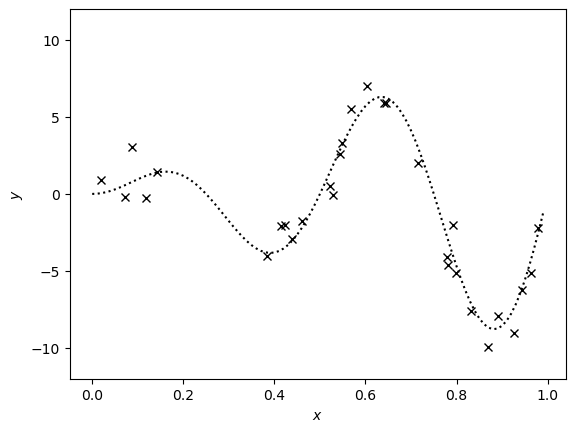

In [259]:
# 人工データセットの可視化
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(0)
X_star = np.arange(0, 1, 0.01)
n_points = 30
f = lambda x: 10 * x * np.sin(4 * np.pi * x)
X = np.sort(np.random.random(size = n_points))
r = f(X) + np.random.normal(0, 1, size = n_points)
plt.ylim(-12, 12)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.plot(X_star, f(X_star), color = "black", linestyle = "dotted")
plt.plot(X, r, "x", color = "black")
plt.show()

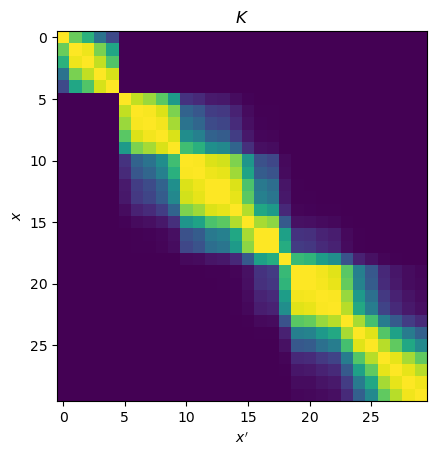

In [260]:
# カーネル行列Kの可視化
def gaussian_kernel(x1, x2, gamma = 100):
    return np.exp(-gamma * (x1 - x2) ** 2)

K = np.zeros((len(X), len(X)))
for i, xi in enumerate(X):
    for j, xj in enumerate(X):
        K[i, j] = gaussian_kernel(xi, xj)

plt.xlabel(r'$x^{\prime}$')
plt.ylabel(r'$x$')
plt.title(r'$K$')
plt.imshow(K)
plt.show()

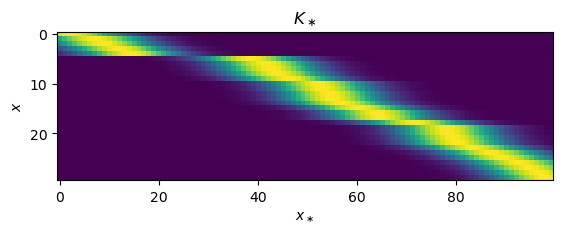

In [261]:
# カーネル行列K_starの可視化
K_star = np.zeros((len(X), len(X_star)))
for i, xi in enumerate(X):
    for j, xj_star in enumerate(X_star):
        K_star[i, j] = gaussian_kernel(xi, xj_star)

plt.xlabel(r'$x_\ast$')
plt.ylabel(r'$x$')
plt.title(r'$K_\ast$')
plt.imshow(K_star)
plt.show()

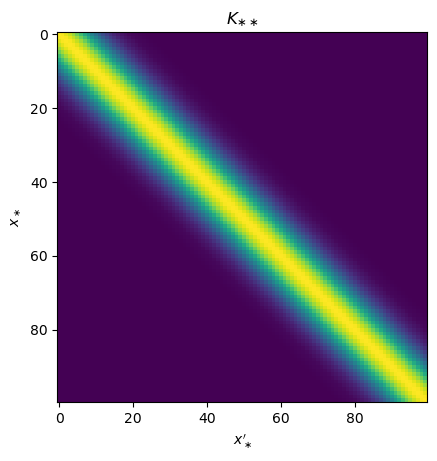

In [262]:
# カーネル行列K_starstarの可視化
K_starstar = np.zeros((len(X_star), len(X_star)))
for i, xi_star in enumerate(X_star):
    for j, xj_star in enumerate(X_star):
        K_starstar[i, j] = gaussian_kernel(xi_star, xj_star)

plt.xlabel(r'$x_\ast^{\prime}$')
plt.ylabel(r'$x_\ast$')
plt.title(r'$K_{\ast\ast}$')
plt.imshow(K_starstar)
plt.show()

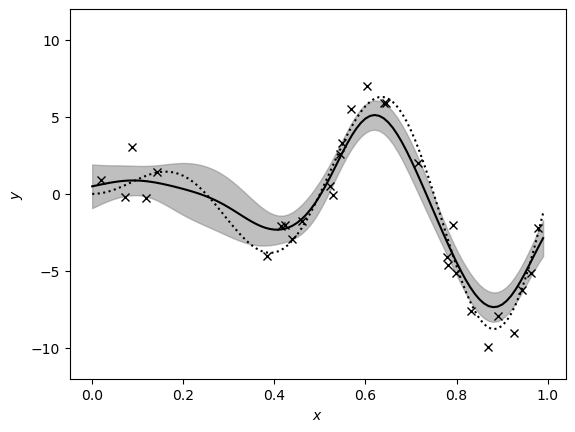

In [263]:
# 人工データセットに対するガウス過程回帰の結果
s = 1
A = np.linalg.inv(K + s * np.eye(K.shape[0]))
mu = np.dot(np.dot(K_star.T, A), r)
sigma = K_starstar - np.dot(np.dot(K_star.T, A), K_star)
plt.ylim(-12, 12)
plt.plot(X_star, f(X_star), color = "black", linestyle = "dotted")
plt.fill_between(X_star, mu - 2 * np.sqrt(np.diag(sigma)), mu + 2 * np.sqrt(np.diag(sigma)), alpha = 0.5, color = "gray")
plt.plot(X_star, mu, color = "black")
plt.plot(X, r, "x", color = "black")
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

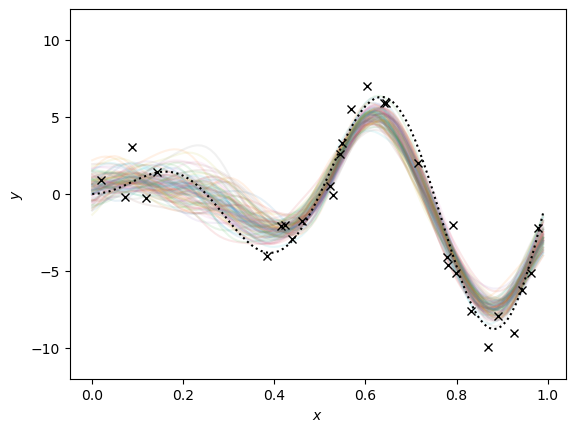

In [265]:
# 多次元正規分布から100回回帰曲線をサンプル
plt.ylim(-12, 12)
for _ in range(100):
    plt.plot(X_star, np.random.multivariate_normal(mu, sigma), alpha = 0.1)
plt.plot(X_star, f(X_star), color = "black", linestyle = "dotted")
plt.plot(X, r, "x", color = "black")
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

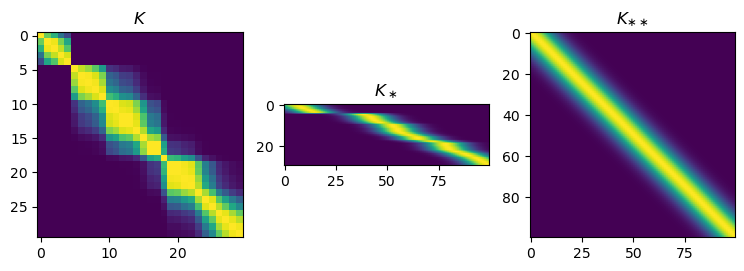

In [266]:
# カーネル行列の高速化
gamma = 100
X = np.expand_dims(X, 0)
X_star = np.expand_dims(X_star, 0)
Q = np.dot(X.T, X)
Q_star = np.dot(X.T, X_star)
Q_starstar = np.dot(X_star.T, X_star)

K = np.exp(-gamma * (np.tile(np.diag(Q), (X.shape[1], 1)).T - 2 * Q + np.tile(np.diag(Q), (X.shape[1], 1))))
K_star = np.exp(-gamma * (np.tile(np.diag(Q), (X_star.shape[1], 1)).T - 2 * Q_star + np.tile(np.diag(Q_starstar), (X.shape[1], 1))))
K_starstar = np.exp(-gamma * (np.tile(np.diag(Q_starstar), (X_star.shape[1], 1)).T
                              - 2 * Q_starstar + np.tile(np.diag(Q_starstar), (X_star.shape[1], 1))))

plt.figure(figsize = (9, 3))
plt.subplot(1, 3, 1)
plt.title(r'$K$')
plt.imshow(K)

plt.subplot(1, 3, 2)
plt.title(r'$K_\ast$')
plt.imshow(K_star)

plt.subplot(1, 3, 3)
plt.title(r'$K_{\ast\ast}$')
plt.imshow(K_starstar)

plt.show()

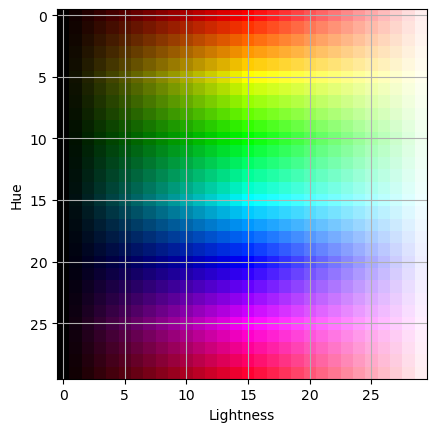

In [267]:
# 解空間の可視化
# HLS色空間のうち、彩度を100%に固定した部分空間を解空間に採用
import colorsys

N = 30
X_im = np.zeros((N, N, 2))
rs = []
xs = []
for i in range(N):
    for j in range(N):
        X_im[i, j, 0] = i / N # Hue
        X_im[i, j, 1] = j / N # Lightness
hl_to_rgb = lambda x: colorsys.hls_to_rgb(x[0], x[1], 1)
X_rgb = np.apply_along_axis(hl_to_rgb, -1, X_im)
plt.imshow(X_rgb)
plt.grid()
plt.xlabel("Lightness")
plt.ylabel("Hue")
plt.show()

In [268]:
# WIP
# GP-UCB
# ガウス過程によって得られる期待値関数の事後分布の期待値と分散を元にUCB値を算出し、UCB値が最大となる解を逐次的に選択

# 未知の入力点の集合
# 解空間に含まれる解全ての入力点に興味があるので、解空間X_imを解の集合として並び替えたもの
X_star = X_im.reshape((N * N, 2)).T

class GPUCBAgent(object):
    def __init__(self):
        self.xs = [] # 選択した解の履歴
        self.rs = [] # 選択した解の評価値の履歴
        self.gamma = 10 # ガウスカーネルに含まれる定数γ
        self.s = 0.5 # 評価値に仮定する分散
        self.alpha = 2 # UCB値を算出する際に標準偏差に乗ずる定数α
        self.Q_starstar = X_star.T.dot(X_star) # カーネル行列K_*とK_**の計算に使用
        self.K_starstar = np.exp(-self.gamma * (np.tile(np.diag(self.Q_starstar), (X_star.shape[1], 1)).T
                                                - 2 * self.Q_starstar + np.tile(np.diag(self.Q_starstar), (X_star.shape[1], 1))))
        self.mu = np.zeros(self.K_starstar.shape[0]) # 期待値関数の事後分布の期待値
        self.sigma = self.K_starstar # 期待値関数の事後分布の分散

    def get_arm(self):
        ucb = self.mu + self.alpha * np.diag(self.sigma)
        return X_star[:, np.argmax(ucb)], ucb
        
    def sample(self, x, r):
        self.xs.append(x)
        self.rs.append(r)
        X = np.array(self.xs).T
        Q = X.T.dot(X)
        Q_star = X.T.dot(X_star)
        K = np.exp(-self.gamma * (np.tile(np.diag(Q), (X.shape[1], 1)).T 
                                  - 2 * Q + np.tile(np.diag(Q), (X.shape[1], 1))))
        K_star = np.exp(-self.gamma * (np.tile(np.diag(Q), (X_star.shape[1], 1)).T
                                      - 2 * Q_star + np.tile(np.diag(self.Q_starstar), (X.shape[1], 1))))
        A = np.linalg.inv(self.s + np.identity(K.shape[0]) + K)
        self.mu = K_star.T.dot(A).dot(self.rs)
        self.sigma = self.K_starstar - K_star.T.dot(A).dot(K_star)

In [269]:
from mpl_toolkits.axes_grid1 import ImageGrid

def visualize(agent, x, f):
    vmax = 1.6
    vmin = -1.6
    contour_linewidth = 0.6
    contour_fontsize = 6
    contour_levels = np.linspace(-2, 2, 17)
    fig = plt.figure()
    
    grid = ImageGrid(fig, 211, nrows_ncols = (1, 2), axes_pad = 0.1)
    grid[0].imshow(X_rgb)
    cs = grid[0].contour(f.reshape(N, N), levels = contour_levels, linewidths = contour_linewidth)
    grid[0].clabel(cs, inline = 1, fontsize = contour_fontsize)
    grid[0].plot(x[1] * N, x[0] * N, "*", markersize = 20, color = "yellow", markeredgecolor = "black")
    grid[0].set_title("Solution space")
    grid[0].set_xticklabels([])
    grid[0].set_yticklabels([])
    
    grid[1].imshow(np.tile(hl_to_rgb(x), (N, N, 1)))
    grid[1].set_title("Proposed color")
    grid[1].set_xticklabels([])
    grid[1].set_yticklabels([])
    
    grid = ImageGrid(fig, 212, nrows_ncols = (1, 3), axes_pad = 0.2, share_all = True,
                     label_mode = "L", cbar_location = "left", cbar_mode = "single")
    im = grid[0].imshow(agent.mu.reshape(N, N), vmin = vmin, vmax = vmax)
    cs = grid[0].contour(agent.mu.reshape(N, N), levels = contour_levels, linewidths = contour_linewidth)
    grid[0].clabel(cs, inline = 1, fontsize = contour_fontsize)
    grid[0].set_title(r'$\mu$')
    grid.cbar_axes[0].colorbar(im)
    
    grid[1].imshow(np.diag(agent.sigma).reshape(N, N), vmin = vmin, vmax = vmax)
    cs = grid[1].contour(np.diag(agent.sigma).reshape(N, N), levels = contour_levels, colors = "white", linewidths = contour_linewidth)
    grid[1].set_title(r'$diag(\Sigma)$')
    grid[1].clabel(cs, inline = 1, fontsize = contour_fontsize)
    
    grid[2].imshow(f.reshape(N, N), vmin = vmin, vmax = vmax)
    cs = grid[2].contour(np.diag(agent.sigma).reshape(N, N), levels = contour_levels, colors = "black", linewidths = contour_linewidth)
    grid[2].clabel(cs, inline = 1, fontsize = contour_fontsize)
    grid[2].set_title("Acquisition function")
    plt.show()

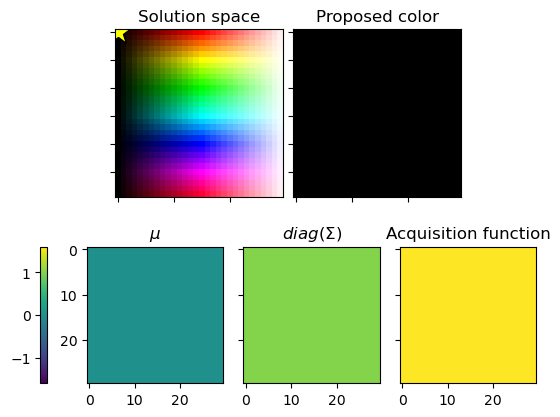

In [270]:
agent = GPUCBAgent()
x, ucb = agent.get_arm()
visualize(agent, x, ucb)

In [271]:
agent.sample(x, -2)

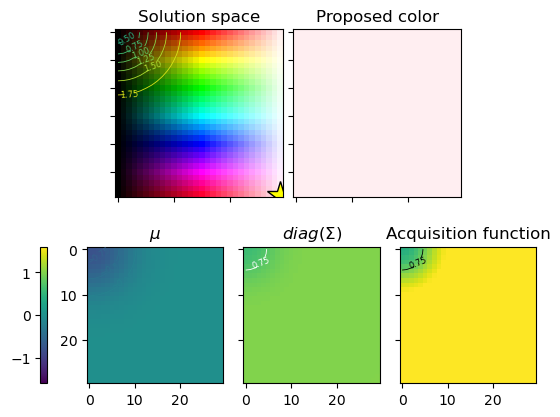

In [272]:
x, ucb = agent.get_arm()
visualize(agent, x, ucb)

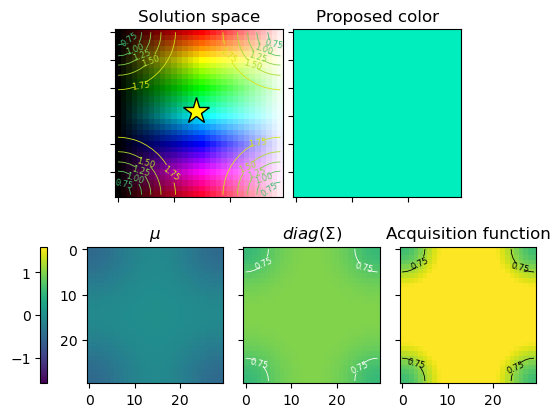

In [273]:
agent.sample(x, -2)
x, ucb = agent.get_arm()
agent.sample(x, -2)
x, ucb = agent.get_arm()
agent.sample(x, -2)
x, ucb = agent.get_arm()
visualize(agent, x, ucb)

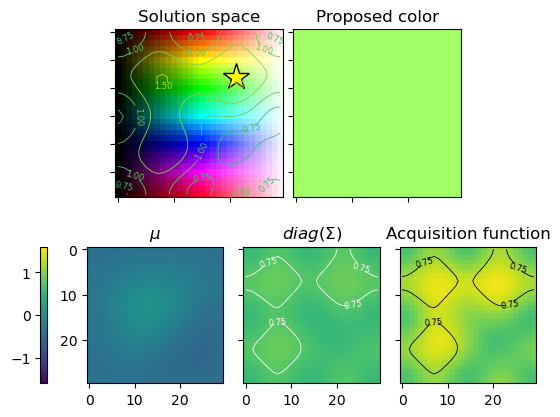

In [274]:
agent.sample(x, -1)
x, ucb = agent.get_arm()
agent.sample(x, -2)
x, ucb = agent.get_arm()
agent.sample(x, -2)
x, ucb = agent.get_arm()
agent.sample(x, -2)
x, ucb = agent.get_arm()
agent.sample(x, -2)
x, ucb = agent.get_arm()
agent.sample(x, -2)
x, ucb = agent.get_arm()
visualize(agent, x, ucb)

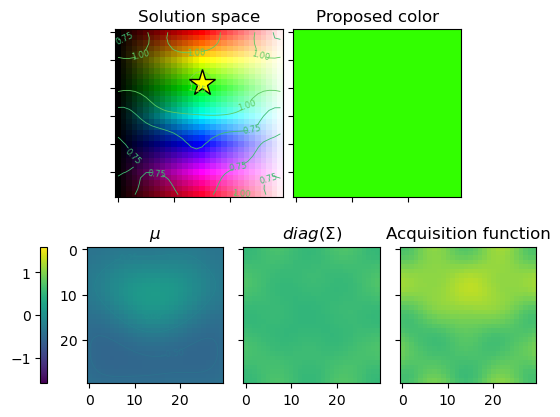

In [275]:
agent.sample(x, -1)
x, ucb = agent.get_arm()
agent.sample(x, -1)
x, ucb = agent.get_arm()
agent.sample(x, -2)
x, ucb = agent.get_arm()
visualize(agent, x, ucb)

In [276]:
agent.sample(x, 2)
x, ucb = agent.get_arm()
agent.sample(x, 2)

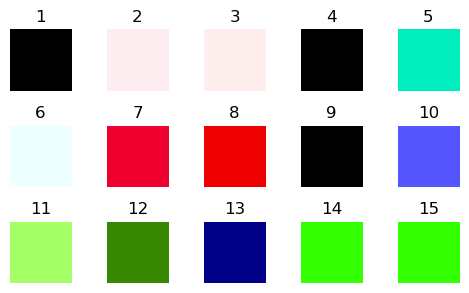

In [277]:
plt.figure(figsize=(5, len(agent.xs) // 5 + 1))
for i, x in enumerate(agent.xs):
  plt.subplot(len(agent.xs) // 5 + 1, 5, i + 1)
  plt.title(i + 1)
  plt.imshow(np.tile(hl_to_rgb(x), (1, 1, 1)))
  plt.axis('off')
plt.tight_layout()
plt.show()

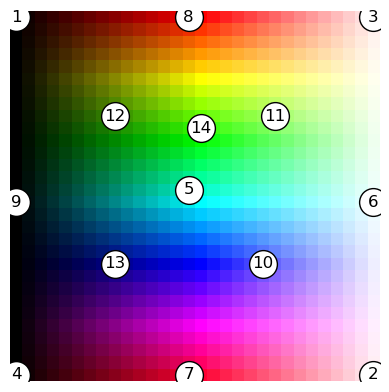

In [278]:
plt.imshow(X_rgb)
for i, x in enumerate(agent.xs[:-1]):
  plt.plot(x[1] * N, x[0] * N, 'o', markersize=20, color='white',
           markeredgecolor='black')
  plt.text(x[1] * N, x[0] * N, str(i + 1), color='black', fontsize=12,
           verticalalignment='center', horizontalalignment='center')
plt.axis('off')
plt.show()

In [279]:
# GP-TS
class GPTSAgent(object):
    def __init__(self):
        self.xs = []
        self.rs = []
        self.gamma = 10
        self.s = 0.5
        self.Q_starstar = X_star.T.dot(X_star)
        self.K_starstar = np.exp(-self.gamma * (np.tile(np.diag(self.Q_starstar), (X_star.shape[1], 1)).T
                                                - 2 * self.Q_starstar + np.tile(np.diag(self.Q_starstar), (X_star.shape[1], 1))))
        self.mu = np.zeros(self.K_starstar.shape[0])
        self.sigma = self.K_starstar

    def get_arm(self):
        f = np.random.multivariate_normal(self.mu, self.sigma)
        return X_star[:, np.argmax(f)], f

    def sample(self, x, r):
        self.xs.append(x)
        self.rs.append(r)
        X = np.array(self.xs).T

        Q = X.T.dot(X)
        Q_star = X.T.dot(X_star)
        K = np.exp(-self.gamma * (np.tile(np.diag(Q), (X.shape[1], 1)).T
                                 - 2 * Q + np.tile(np.diag(Q), (X.shape[1], 1))))
        K_star = np.exp(-self.gamma * (np.tile(np.diag(Q), (X_star.shape[1], 1)).T
                                      - 2 * Q_star + np.tile(np.diag(self.Q_starstar), (X.shape[1], 1))))
        A = np.linalg.inv(self.s + np.identity(K.shape[0]) + K)
        self.mu = K_star.T.dot(A).dot(self.rs)
        self.sigma = self.K_starstar - K_star.T.dot(A).dot(K_star)

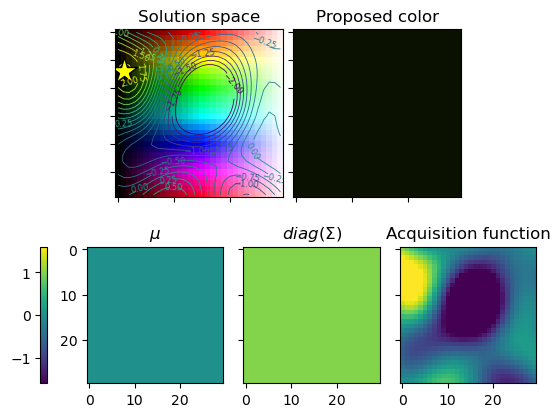

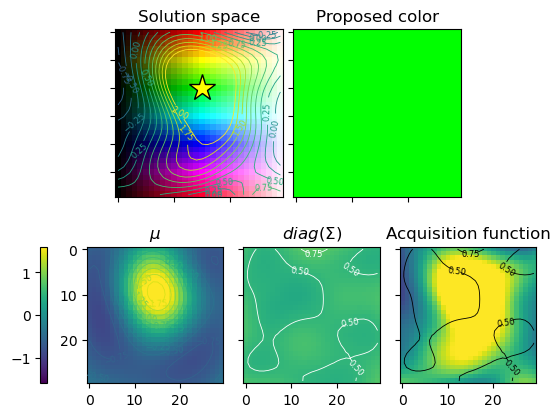

In [280]:
np.random.seed(1)
agent = GPTSAgent()
x, f = agent.get_arm()
visualize(agent, x, f)
agent.sample(x, -2)
x, f = agent.get_arm()
agent.sample(x, -2)
x, f = agent.get_arm()
agent.sample(x, -2)
x, f = agent.get_arm()
agent.sample(x, -2)
x, f = agent.get_arm()
agent.sample(x, -2)
x, f = agent.get_arm()
agent.sample(x, -2)
x, f = agent.get_arm()
agent.sample(x, -2)
x, f = agent.get_arm()
agent.sample(x, -2)
x, f = agent.get_arm()
agent.sample(x, -2)
x, f = agent.get_arm()
agent.sample(x, -2)
x, f = agent.get_arm()
agent.sample(x, -2)
x, f = agent.get_arm()
agent.sample(x, -2)
x, f = agent.get_arm()
agent.sample(x, -2)
x, f = agent.get_arm()
agent.sample(x, -2)
x, f = agent.get_arm()
agent.sample(x, -2)
x, f = agent.get_arm()
agent.sample(x, -2)
x, f = agent.get_arm()
agent.sample(x, -2)
x, f = agent.get_arm()
agent.sample(x, 2)
x, f = agent.get_arm()
agent.sample(x, 2)
x, f = agent.get_arm()
agent.sample(x, 2)
x, f = agent.get_arm()
visualize(agent, x, f)
agent.sample(x, 2)

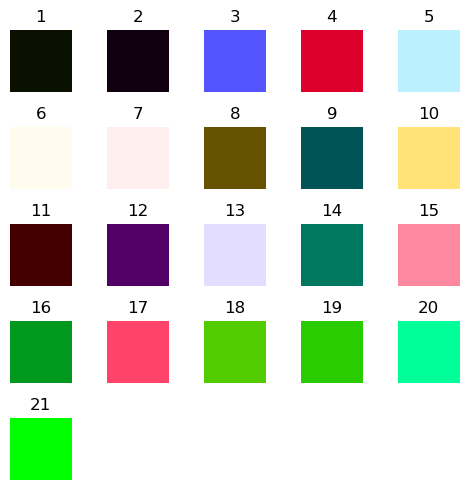

In [281]:
plt.figure(figsize=(5, len(agent.xs) // 5 + 1))
for i, x in enumerate(agent.xs):
  plt.subplot(len(agent.xs) // 5 + 1, 5, i + 1)
  plt.title(i + 1)
  plt.imshow(np.tile(hl_to_rgb(x), (1, 1, 1)))
  plt.axis('off')
plt.tight_layout()
plt.show()

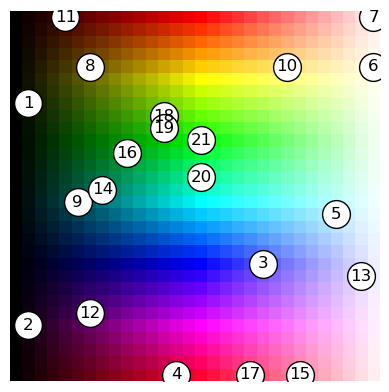

In [284]:
plt.imshow(X_rgb)
for i, x in enumerate(agent.xs):
  plt.plot(x[1] * N, x[0] * N, 'o', markersize=20, color='white',
           markeredgecolor='black')
  plt.text(x[1] * N, x[0] * N, str(i + 1), color='black', fontsize=12,
           verticalalignment='center', horizontalalignment='center')
plt.axis('off')
plt.show()